In [1]:
# Data exploration and manipulation
import pandas as pd
import numpy as np
import missingno as msno
from scipy import stats

# Data Transformation
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Graphics
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

# Options
pd.set_option("display.max_columns",200)
%matplotlib inline

# Other librarys
import joblib
import pickle
import sys
from sklearn.pipeline import make_pipeline

# Model performance related libraries
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

In [2]:
# user libraries
sys.path.insert(1, '../../usr_lib/')
import utilities

In [3]:
data_path = '../../data/modulo2/examen/DataExam1/'

In [4]:
df = pd.read_csv(data_path + 'airlines_train.csv', sep=',', encoding='utf8')
test = pd.read_csv(data_path + 'airlines_test.csv', sep=',', encoding='utf8')

In [5]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,33850,EV,5159,MEM,HSV,4,1180,60,0
1,106251,MQ,4482,RDU,DCA,2,500,60,0
2,295756,XE,2006,GSO,EWR,6,360,90,0
3,431625,DL,2109,MSP,DEN,6,1320,126,1
4,49991,HA,194,HNL,OGG,5,1075,37,0


In [6]:
df.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,33850,EV,5159,MEM,HSV,4,1180,60,0
1,106251,MQ,4482,RDU,DCA,2,500,60,0
2,295756,XE,2006,GSO,EWR,6,360,90,0
3,431625,DL,2109,MSP,DEN,6,1320,126,1
4,49991,HA,194,HNL,OGG,5,1075,37,0


In [7]:
var_c = ['Time', 'Length']
var_v = ['Airline', 'AirportFrom', 'AirportTo','DayOfWeek']

In [8]:
df = utilities.rename_variables(df, var_c, 'c_')
test = utilities.rename_variables(test, var_c, 'c_')
df = utilities.rename_variables(df, var_v, 'v_')
test = utilities.rename_variables(test, var_v, 'v_')

In [9]:
df['Flight'].value_counts()

16      338
9       319
5       318
8       318
28      293
       ... 
5559      1
5606      1
3573      1
3195      1
3413      1
Name: Flight, Length: 6581, dtype: int64

In [10]:
df.drop(columns=['Flight'], axis=1, inplace=True)
test.drop(columns=['Flight'], axis=1, inplace=True)

In [11]:
df.rename(columns={'Delay':'tgt'}, inplace=True)

<AxesSubplot:>

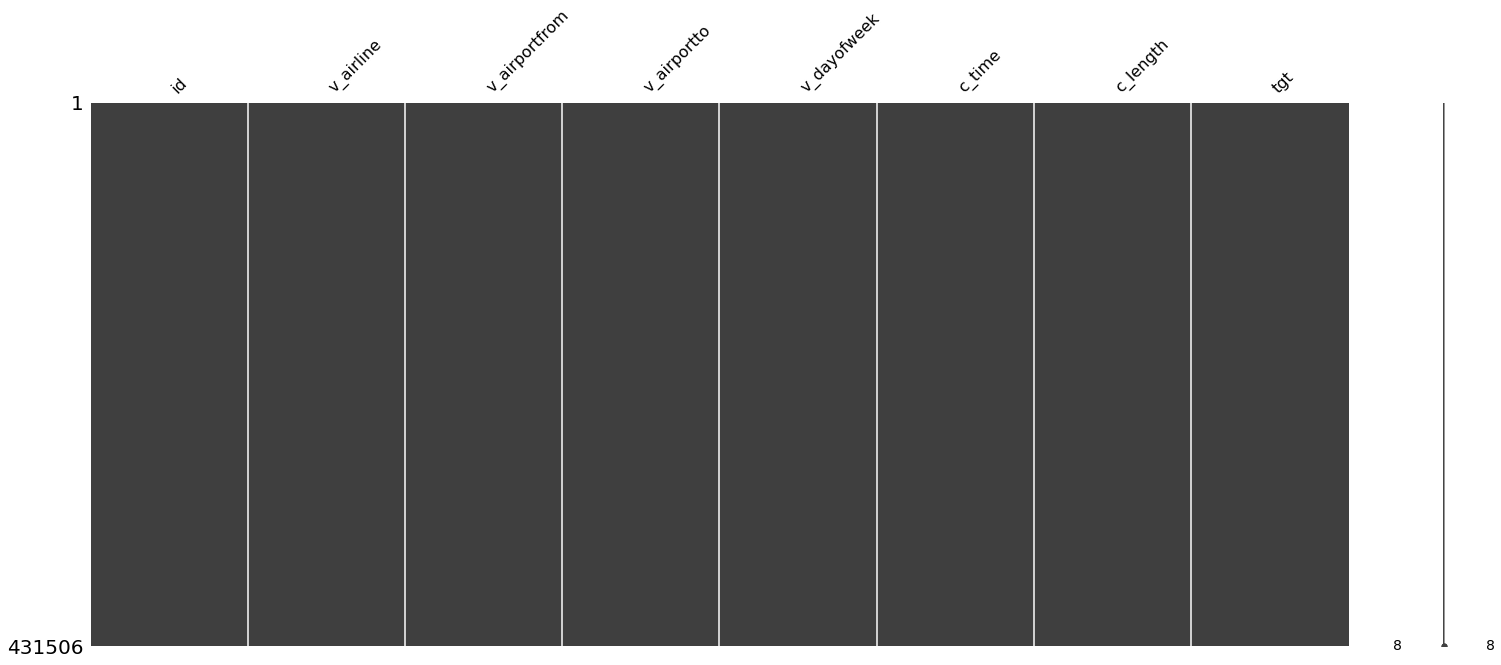

In [12]:
msno.matrix(df)

In [13]:
df.drop(columns=['id'], axis=1, inplace=True)

In [14]:
def transforma_hora(x):
    x=int(x)
    if x <= 300:
        return 'madrugada'
    elif x > 300 and x <= 660:
        return 'mañana'
    elif x > 660 and x <= 1020:
        return 'dia'
    elif x > 1020:
        return 'noche'

In [15]:
for i in range(25):
    print(i * 60)

0
60
120
180
240
300
360
420
480
540
600
660
720
780
840
900
960
1020
1080
1140
1200
1260
1320
1380
1440


In [16]:
df['c_time_discretized'] = df['c_time'].map(transforma_hora)
test['c_time_discretized'] = test['c_time'].map(transforma_hora)

In [17]:
df.head()

,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,tgt,c_time_discretized
0,EV,MEM,HSV,4,1180,60,0,noche
1,MQ,RDU,DCA,2,500,60,0,mañana
2,XE,GSO,EWR,6,360,90,0,mañana
3,DL,MSP,DEN,6,1320,126,1,noche
4,HA,HNL,OGG,5,1075,37,0,noche


In [18]:
aux = list(set(pd.cut(df['c_length'], bins=10)))
label = 'intervals_length'
save_dict = {label:[str(a)[1:-2].split(',') for a in aux]}
import json
file_name = label+'.json'
with open(file_name, 'w') as outfile:
    json.dump(save_dict, outfile)

In [19]:
with open(file_name) as json_file:
    cuts= json.load(json_file)
    print(cuts)

{'intervals_length': [['458.5', ' 524.'], ['65.5', ' 131.'], ['-0.655', ' 65.'], ['327.5', ' 393.'], ['131.0', ' 196.'], ['262.0', ' 327.'], ['589.5', ' 655.'], ['524.0', ' 589.'], ['393.0', ' 458.'], ['196.5', ' 262.']]}


In [20]:
intervals = pd.Series(cuts.get(label)).map(lambda x:pd.Interval(float(x[0]), float(x[1]), closed='right'))
intervals = dict(zip(intervals, [str(a) for a in intervals]))

In [21]:
def len_cut(df, column, interval_dict, label='_interval'):
    df[column + label] = df[column].map(interval_dict)
    return df

In [22]:
df = len_cut(df, 'c_length', intervals)

In [23]:
df

,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,tgt,c_time_discretized,c_length_interval
0,EV,MEM,HSV,4,1180,60,0,noche,"(-0.655, 65.0]"
1,MQ,RDU,DCA,2,500,60,0,mañana,"(-0.655, 65.0]"
2,XE,GSO,EWR,6,360,90,0,mañana,"(65.5, 131.0]"
3,DL,MSP,DEN,6,1320,126,1,noche,"(65.5, 131.0]"
4,HA,HNL,OGG,5,1075,37,0,noche,"(-0.655, 65.0]"
...,...,...,...,...,...,...,...,...,...
431501,DL,MCO,ATL,3,1050,101,1,noche,"(65.5, 131.0]"
431502,US,PHX,LAX,5,1180,85,0,noche,"(65.5, 131.0]"
431503,DL,SAT,ATL,7,803,135,1,dia,"(131.0, 196.0]"
431504,UA,DEN,LGA,7,1074,215,1,noche,"(196.5, 262.0]"


In [24]:
def normaliza_counteo(df, column, threshold = 0.05, label='cat', other_label='others', new_col=True):
    aux = pd.DataFrame(df[column].value_counts(1, dropna=False))
    aux[label] = aux.index
    aux[label] = aux[label].map(lambda x:x if aux.loc[x, column] > threshold else other_label)
    aux_dict = dict(zip(aux.index, aux[label]))
    if new_col:
        df[column + '_norm'] = df[column].map(aux_dict)
    else:
        df[column] = df[column].map(aux_dict)
    return(df, aux_dict)


def prop_delay(df, column, tar='tgt', label='_%tgt', id_='id'):
    aux = df[[column, tar, id_]].pivot_table(columns=tar, index=column, aggfunc='count', values=id_)
    aux['%tgt'] = aux.apply(lambda x:x/sum(x), axis=1)[1]
    delay_aux = dict(zip(aux.index, aux['%tgt']))
    df[column + label] = df[column].map(delay_aux).fillna(0)
    return(df, delay_aux)
    
def woe(df, column, tar, label='_woe'):
    df[column].fillna('missing', inplace=True)
    aux = df[[tar, column]].pivot_table(index=column, columns=tar, aggfunc='size')
    woe = aux.apply(lambda x:x/sum(x)).apply(lambda x:np.log(x[1]/x[0]), axis=1)
    aux['WoE'] = woe
    aux_dict = dict(zip(aux.index, aux['WoE']))
    df[column + label] = df[column].map(aux_dict)
    return(df, aux_dict)

In [25]:
df_aux = df.copy()
df.head()

,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,tgt,c_time_discretized,c_length_interval
0,EV,MEM,HSV,4,1180,60,0,noche,"(-0.655, 65.0]"
1,MQ,RDU,DCA,2,500,60,0,mañana,"(-0.655, 65.0]"
2,XE,GSO,EWR,6,360,90,0,mañana,"(65.5, 131.0]"
3,DL,MSP,DEN,6,1320,126,1,noche,"(65.5, 131.0]"
4,HA,HNL,OGG,5,1075,37,0,noche,"(-0.655, 65.0]"


In [26]:

df_aux['id'] = df_aux.index
df_aux['tgt'] = df['tgt']
del_cols = ['v_airline', 'v_airportfrom', 'v_airportto', 'v_dayofweek']
del_dict = dict()
for c in del_cols:
    delay_aux, del_dict[c] = prop_delay(df_aux, c)
    
disc_columns = ['v_airline', 'v_airportfrom', 'v_airportto', 'v_dayofweek', 'c_time_discretized'
                , 'c_length_interval']
norm_dict = dict()
for c in disc_columns:
    aux_norm, norm_dict[c] = normaliza_counteo(delay_aux, c, threshold=0.02)
    
columns = [c + '_norm' for c in disc_columns]
woes_dict = {}
for c in columns:
    aux_woe, woes_dict[c] = woe(aux_norm, c, 'tgt')

In [27]:
aux_woe.head()

,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,tgt,c_time_discretized,c_length_interval,id,v_airline_%tgt,v_airportfrom_%tgt,v_airportto_%tgt,v_dayofweek_%tgt,v_airline_norm,v_airportfrom_norm,v_airportto_norm,v_dayofweek_norm,c_time_discretized_norm,c_length_interval_norm,v_airline_norm_woe,v_airportfrom_norm_woe,v_airportto_norm_woe,v_dayofweek_norm_woe,c_time_discretized_norm_woe,c_length_interval_norm_woe
0,EV,MEM,HSV,4,1180,60,0,noche,"(-0.655, 65.0]",0,0.404720,0.323302,0.351506,0.451721,EV,others,others,4,noche,"(-0.655, 65.0]",-0.168420,-0.041493,0.070500,0.023694,0.286370,-0.081577
1,MQ,RDU,DCA,2,500,60,0,mañana,"(-0.655, 65.0]",1,0.350929,0.403771,0.318627,0.446810,MQ,others,others,2,mañana,"(-0.655, 65.0]",-0.397541,-0.041493,0.070500,0.003845,-0.423771,-0.081577
2,XE,GSO,EWR,6,360,90,0,mañana,"(65.5, 131.0]",2,0.377893,0.346880,0.474248,0.402647,XE,others,others,6,mañana,"(65.5, 131.0]",-0.281087,-0.041493,0.070500,-0.177035,-0.423771,-0.048801
3,DL,MSP,DEN,6,1320,126,1,noche,"(65.5, 131.0]",3,0.451203,0.488369,0.434418,0.402647,DL,others,DEN,6,noche,"(65.5, 131.0]",0.021605,-0.041493,-0.046433,-0.177035,0.286370,-0.048801
4,HA,HNL,OGG,5,1075,37,0,noche,"(-0.655, 65.0]",4,0.319245,0.323571,0.305263,0.416797,others,others,others,5,noche,"(-0.655, 65.0]",-0.239969,-0.041493,0.070500,-0.118521,0.286370,-0.081577


In [28]:
for c in del_cols:
    df[c+'_%tgt'] = df[c].map(lambda x:del_dict.get(c).get(x, 0))

In [29]:
for c in disc_columns:
    df[c+'_norm'] = df[c].map(lambda x:norm_dict.get(c).get(x, 'others'))

In [30]:
for c in columns:
    df[c+'_woe'] = df[c].map(lambda x:woes_dict.get(c).get(x, 0))

In [31]:
df

,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,tgt,c_time_discretized,c_length_interval,v_airline_%tgt,v_airportfrom_%tgt,v_airportto_%tgt,v_dayofweek_%tgt,v_airline_norm,v_airportfrom_norm,v_airportto_norm,v_dayofweek_norm,c_time_discretized_norm,c_length_interval_norm,v_airline_norm_woe,v_airportfrom_norm_woe,v_airportto_norm_woe,v_dayofweek_norm_woe,c_time_discretized_norm_woe,c_length_interval_norm_woe
0,EV,MEM,HSV,4,1180,60,0,noche,"(-0.655, 65.0]",0.404720,0.323302,0.351506,0.451721,EV,others,others,4,noche,"(-0.655, 65.0]",-0.168420,-0.041493,0.070500,0.023694,0.286370,-0.081577
1,MQ,RDU,DCA,2,500,60,0,mañana,"(-0.655, 65.0]",0.350929,0.403771,0.318627,0.446810,MQ,others,others,2,mañana,"(-0.655, 65.0]",-0.397541,-0.041493,0.070500,0.003845,-0.423771,-0.081577
2,XE,GSO,EWR,6,360,90,0,mañana,"(65.5, 131.0]",0.377893,0.346880,0.474248,0.402647,XE,others,others,6,mañana,"(65.5, 131.0]",-0.281087,-0.041493,0.070500,-0.177035,-0.423771,-0.048801
3,DL,MSP,DEN,6,1320,126,1,noche,"(65.5, 131.0]",0.451203,0.488369,0.434418,0.402647,DL,others,DEN,6,noche,"(65.5, 131.0]",0.021605,-0.041493,-0.046433,-0.177035,0.286370,-0.048801
4,HA,HNL,OGG,5,1075,37,0,noche,"(-0.655, 65.0]",0.319245,0.323571,0.305263,0.416797,others,others,others,5,noche,"(-0.655, 65.0]",-0.239969,-0.041493,0.070500,-0.118521,0.286370,-0.081577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431501,DL,MCO,ATL,3,1050,101,1,noche,"(65.5, 131.0]",0.451203,0.433408,0.384408,0.471982,DL,others,ATL,3,noche,"(65.5, 131.0]",0.021605,-0.041493,-0.253465,0.105225,0.286370,-0.048801
431502,US,PHX,LAX,5,1180,85,0,noche,"(65.5, 131.0]",0.336633,0.440629,0.491501,0.416797,US,PHX,LAX,5,noche,"(65.5, 131.0]",-0.460919,-0.021194,0.183417,-0.118521,0.286370,-0.048801
431503,DL,SAT,ATL,7,803,135,1,dia,"(131.0, 196.0]",0.451203,0.419605,0.384408,0.453525,DL,others,ATL,7,dia,"(131.0, 196.0]",0.021605,-0.041493,-0.253465,0.030978,0.175831,0.005241
431504,UA,DEN,LGA,7,1074,215,1,noche,"(196.5, 262.0]",0.323377,0.476458,0.394471,0.453525,UA,DEN,others,7,noche,"(196.5, 262.0]",-0.520880,0.123178,0.070500,0.030978,0.286370,0.266342


In [32]:
predictors=([c for c in df.columns if 'woe' in c] +
           [c for c in df.columns if '%tgt' in c])

In [33]:
X = df[predictors].copy()
X.fillna(0, inplace=True)
y = df['tgt']

In [34]:
from sklearn.feature_selection import SelectKBest
kb = SelectKBest(k = 10)
kb.fit(df[predictors].fillna(0), y)

SelectKBest()

In [35]:
kb.get_support(indices=True)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [36]:
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.decomposition import PCA

lr = LogisticRegression()
rr = RidgeClassifier(alpha=.5)
svc = SVC(kernel='poly')
knn = KNeighborsClassifier()

In [37]:
def pca(df, threshold=None, components=2):
    mm = MinMaxScaler()
    df = pd.DataFrame(mm.fit_transform(df), columns = df.columns)
    xs = df
    if threshold:
        v = 0
        k = components
        while v < threshold:
            pca = PCA(n_components=k)
            pca.fit(xs)
            v=sum(pca.explained_variance_ratio_)
            k+=1
        xp = pd.DataFrame(pca.transform(xs), columns = [f'P_{i}' for i in range(k-1)])
        return(xp, pca)
    else:
        k = components
        pca = PCA(n_components = k)
        pca.fit(xs)
        xp=pd.DataFrame(pca.transform(xs), columns = [f'P_{i}' for i in range(k)])
        return(xp, pca)

In [38]:
X, pca_ = pca(X, components=3)

In [39]:
knn.fit(X,y)

KNeighborsClassifier()

In [40]:
recall_score(y, knn.predict(X))

0.6412462121409006

In [41]:
lr.fit(X,y)

LogisticRegression()

In [42]:
recall_score(y, lr.predict(X))

0.44393448757998033

In [43]:
test

,id,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,c_time_discretized
0,285098,FL,BWI,MCO,5,760,144,dia
1,512979,AA,RNO,DFW,4,710,190,dia
2,131961,OO,ACV,SFO,3,958,74,dia
3,173271,OO,SFO,PSC,5,1255,109,noche
4,130219,WN,LAS,ONT,3,860,55,dia
...,...,...,...,...,...,...,...,...
107872,369423,US,ABE,CLT,3,530,106,mañana
107873,65290,OH,SDF,CVG,6,1035,48,noche
107874,141091,AA,SLC,DFW,4,500,170,mañana
107875,170948,AA,BWI,DFW,5,1110,220,noche


In [44]:
test = len_cut(test, 'c_length', intervals)

In [45]:
for c in columns:
    aux_woe, woes_dict[c] = woe(aux_norm, c, 'tgt')

for c in del_cols:
    test[c+'_%tgt'] = test[c].map(lambda x:del_dict.get(c).get(x, 0))

for c in disc_columns:
    test[c+'_norm'] = test[c].map(lambda x:norm_dict.get(c).get(x, 'others'))

for c in columns:
    test[c+'_woe'] = test[c].map(lambda x:woes_dict.get(c).get(x, 0))

In [46]:
test

,id,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,c_time_discretized,c_length_interval,v_airline_%tgt,v_airportfrom_%tgt,v_airportto_%tgt,v_dayofweek_%tgt,v_airline_norm,v_airportfrom_norm,v_airportto_norm,v_dayofweek_norm,c_time_discretized_norm,c_length_interval_norm,v_airline_norm_woe,v_airportfrom_norm_woe,v_airportto_norm_woe,v_dayofweek_norm_woe,c_time_discretized_norm_woe,c_length_interval_norm_woe
0,285098,FL,BWI,MCO,5,760,144,dia,"(131.0, 196.0]",0.302160,0.574595,0.492380,0.416797,FL,others,others,5,dia,"(131.0, 196.0]",-0.619616,-0.041493,0.070500,-0.118521,0.175831,0.005241
1,512979,AA,RNO,DFW,4,710,190,dia,"(131.0, 196.0]",0.389012,0.579646,0.320081,0.451721,AA,others,DFW,4,dia,"(131.0, 196.0]",-0.234052,-0.041493,-0.535983,0.023694,0.175831,0.005241
2,131961,OO,ACV,SFO,3,958,74,dia,"(65.5, 131.0]",0.452649,0.539419,0.528162,0.471982,OO,others,SFO,3,dia,"(65.5, 131.0]",0.027443,-0.041493,0.330180,0.105225,0.175831,-0.048801
3,173271,OO,SFO,PSC,5,1255,109,noche,"(65.5, 131.0]",0.452649,0.533176,0.410959,0.416797,OO,SFO,others,5,noche,"(65.5, 131.0]",0.027443,0.350316,0.070500,-0.118521,0.286370,-0.048801
4,130219,WN,LAS,ONT,3,860,55,dia,"(-0.655, 65.0]",0.698622,0.557901,0.635317,0.471982,WN,LAS,others,3,dia,"(-0.655, 65.0]",1.058158,0.450064,0.070500,0.105225,0.175831,-0.081577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107872,369423,US,ABE,CLT,3,530,106,mañana,"(65.5, 131.0]",0.336633,0.336996,0.317863,0.471982,US,others,CLT,3,mañana,"(65.5, 131.0]",-0.460919,-0.041493,-0.546195,0.105225,-0.423771,-0.048801
107873,65290,OH,SDF,CVG,6,1035,48,noche,"(-0.655, 65.0]",0.278590,0.457539,0.349388,0.402647,OH,others,others,6,noche,"(-0.655, 65.0]",-0.734053,-0.041493,0.070500,-0.177035,0.286370,-0.081577
107874,141091,AA,SLC,DFW,4,500,170,mañana,"(131.0, 196.0]",0.389012,0.531440,0.320081,0.451721,AA,others,DFW,4,mañana,"(131.0, 196.0]",-0.234052,-0.041493,-0.535983,0.023694,-0.423771,0.005241
107875,170948,AA,BWI,DFW,5,1110,220,noche,"(196.5, 262.0]",0.389012,0.574595,0.320081,0.416797,AA,others,DFW,5,noche,"(196.5, 262.0]",-0.234052,-0.041493,-0.535983,-0.118521,0.286370,0.266342


In [47]:
Xt = test[predictors]

In [48]:
Xt.fillna(0, inplace=True)

/home/sqpr14_/anaconda3/envs/dss/lib/python3.8/site-packages/pandas/core/frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [49]:
Xt, pca_ = pca(Xt, components=3)

In [53]:
test['Delay'] = pd.Series(knn.predict(Xt))

In [54]:
test

,id,v_airline,v_airportfrom,v_airportto,v_dayofweek,c_time,c_length,c_time_discretized,c_length_interval,v_airline_%tgt,v_airportfrom_%tgt,v_airportto_%tgt,v_dayofweek_%tgt,v_airline_norm,v_airportfrom_norm,v_airportto_norm,v_dayofweek_norm,c_time_discretized_norm,c_length_interval_norm,v_airline_norm_woe,v_airportfrom_norm_woe,v_airportto_norm_woe,v_dayofweek_norm_woe,c_time_discretized_norm_woe,c_length_interval_norm_woe,Delay
0,285098,FL,BWI,MCO,5,760,144,dia,"(131.0, 196.0]",0.302160,0.574595,0.492380,0.416797,FL,others,others,5,dia,"(131.0, 196.0]",-0.619616,-0.041493,0.070500,-0.118521,0.175831,0.005241,1
1,512979,AA,RNO,DFW,4,710,190,dia,"(131.0, 196.0]",0.389012,0.579646,0.320081,0.451721,AA,others,DFW,4,dia,"(131.0, 196.0]",-0.234052,-0.041493,-0.535983,0.023694,0.175831,0.005241,1
2,131961,OO,ACV,SFO,3,958,74,dia,"(65.5, 131.0]",0.452649,0.539419,0.528162,0.471982,OO,others,SFO,3,dia,"(65.5, 131.0]",0.027443,-0.041493,0.330180,0.105225,0.175831,-0.048801,0
3,173271,OO,SFO,PSC,5,1255,109,noche,"(65.5, 131.0]",0.452649,0.533176,0.410959,0.416797,OO,SFO,others,5,noche,"(65.5, 131.0]",0.027443,0.350316,0.070500,-0.118521,0.286370,-0.048801,0
4,130219,WN,LAS,ONT,3,860,55,dia,"(-0.655, 65.0]",0.698622,0.557901,0.635317,0.471982,WN,LAS,others,3,dia,"(-0.655, 65.0]",1.058158,0.450064,0.070500,0.105225,0.175831,-0.081577,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107872,369423,US,ABE,CLT,3,530,106,mañana,"(65.5, 131.0]",0.336633,0.336996,0.317863,0.471982,US,others,CLT,3,mañana,"(65.5, 131.0]",-0.460919,-0.041493,-0.546195,0.105225,-0.423771,-0.048801,1
107873,65290,OH,SDF,CVG,6,1035,48,noche,"(-0.655, 65.0]",0.278590,0.457539,0.349388,0.402647,OH,others,others,6,noche,"(-0.655, 65.0]",-0.734053,-0.041493,0.070500,-0.177035,0.286370,-0.081577,0
107874,141091,AA,SLC,DFW,4,500,170,mañana,"(131.0, 196.0]",0.389012,0.531440,0.320081,0.451721,AA,others,DFW,4,mañana,"(131.0, 196.0]",-0.234052,-0.041493,-0.535983,0.023694,-0.423771,0.005241,0
107875,170948,AA,BWI,DFW,5,1110,220,noche,"(196.5, 262.0]",0.389012,0.574595,0.320081,0.416797,AA,others,DFW,5,noche,"(196.5, 262.0]",-0.234052,-0.041493,-0.535983,-0.118521,0.286370,0.266342,0


In [55]:
test[['id', 'Delay']].to_csv('PicoLaraAlbertoIsaac_ailines.csv', index=False)